In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import pickle
import dabench as dab

from matplotlib.gridspec import GridSpec

# Time plot

In [2]:
var4d_time_df = pd.read_csv('./out/l96/var4d_df_time_v33_3outer_test.csv')
bp_time_df = pd.read_csv('./out/l96/bp_df_time_v33_withraytune_hessian_epochs3_test.csv')
var4d_time_df_mean = var4d_time_df.groupby('system_dim').mean()
bp_time_df_mean= bp_time_df.groupby('system_dim').mean()

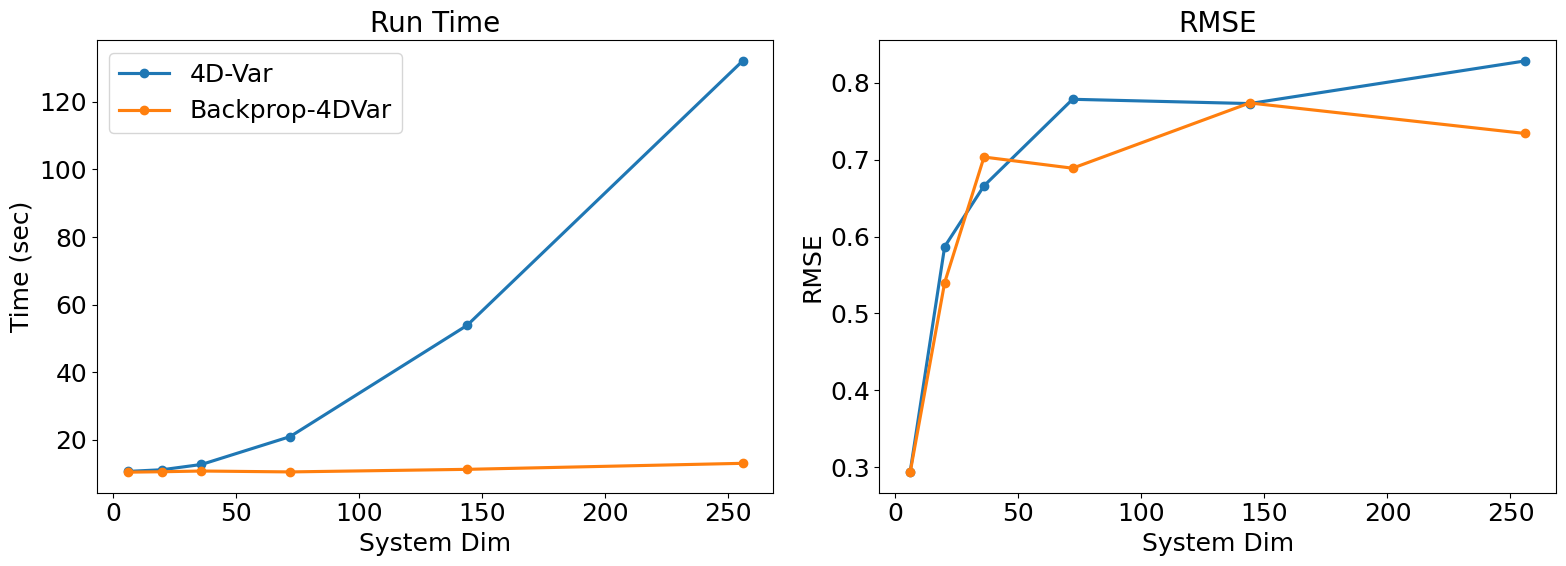

In [3]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
var4d_time_df_mean['time'].plot(ax=axs[0], style='.-', markersize=12, lw=2.25)
bp_time_df_mean['time'].plot(ax=axs[0], style='.-', markersize=12, lw=2.25)
axs[0].set_ylabel('Time (sec)')
axs[0].legend(labels=['4D-Var', 'Backprop-4DVar'])
var4d_time_df_mean['rmse'].plot(ax=axs[1], style='.-', markersize=12, lw=2.25)
bp_time_df_mean['rmse'].plot(ax=axs[1], style='.-', markersize=12, lw=2.25)
axs[1].set_ylabel('RMSE')
axs[0].set_xlabel('System Dim')
axs[1].set_xlabel('System Dim')
axs[0].set_title('Run Time', size=20)
axs[1].set_title('RMSE', size=20)
fig.tight_layout()
# fig.suptitle('4DVar vs. Backprop 4DVar: Lorenz96 with increasing system size \n(Mean of 5 runs)', y=1.08, size=22)

In [4]:
x = var4d_time_df_mean.index
y = var4d_time_df_mean['time']

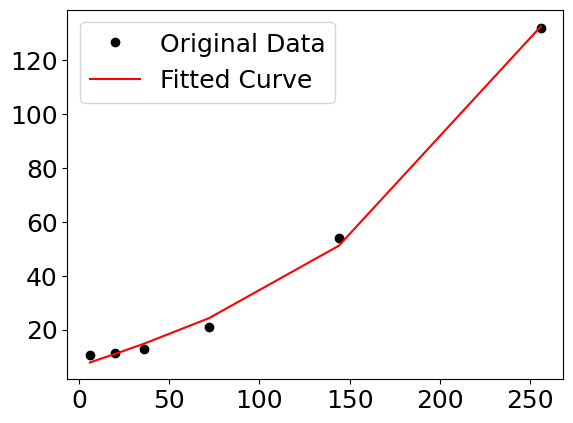

In [5]:
def func(x, a, b,c ):
    return a + b*x + c*x**3

popt, pcov = scipy.optimize.curve_fit(func, x, y)


plt.figure()
plt.plot(x, y, 'ko', label="Original Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [6]:
x = var4d_time_df_mean.index
y = bp_time_df_mean['time']

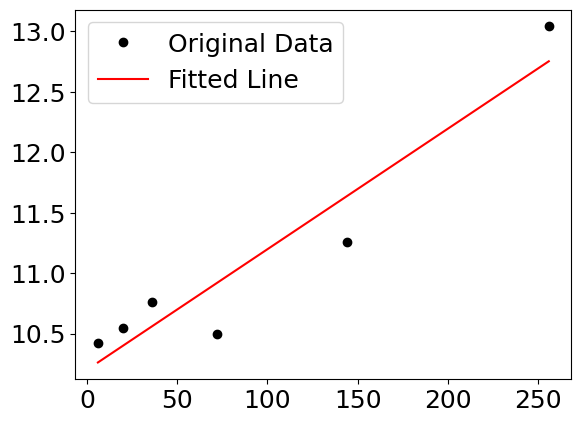

In [7]:
def func(x, a, b):
    return a + b*x

popt, pcov = scipy.optimize.curve_fit(func, x, y)


plt.figure()
plt.plot(x, y, 'ko', label="Original Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Line")
plt.legend()
plt.show()

# Heatmap

In [8]:
var4d_experiment_df = pd.read_csv('./out/l96/var4d_df_obs_v34_3outer_30runs_test.csv')
bp_experiment_df = pd.read_csv('./out/l96/bp_df_obs_v34_hessian_raytune_30runs_test.csv')

In [9]:
var4d_experiment_df['rmse_diff'] = var4d_experiment_df['rmse'] - bp_experiment_df['rmse']

In [10]:
diff_df_sd = var4d_experiment_df.groupby(['obs_location_count','obs_sd']).std()
var4d_experiment_df = var4d_experiment_df.groupby(['obs_location_count','obs_sd']).mean()
bp_experiment_df = bp_experiment_df.groupby(['obs_location_count','obs_sd']).mean()

In [11]:
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2.0]

In [12]:
bp_array = np.flipud((bp_experiment_df['rmse'].values.reshape((len(num_obs_list), len(obs_error_list)))).T)
var4d_array = np.flipud((var4d_experiment_df['rmse'].values.reshape((len(num_obs_list), len(obs_error_list)))).T)

In [13]:
diff_array_sd = np.flipud((diff_df_sd['rmse_diff'].values.reshape((len(num_obs_list), len(obs_error_list)))).T)

In [14]:
diff_array = var4d_array_mean = np.flipud((var4d_experiment_df['rmse_diff'].values.reshape((len(num_obs_list), len(obs_error_list)))).T)

In [15]:
diff_array_sd  = diff_array_sd / var4d_array

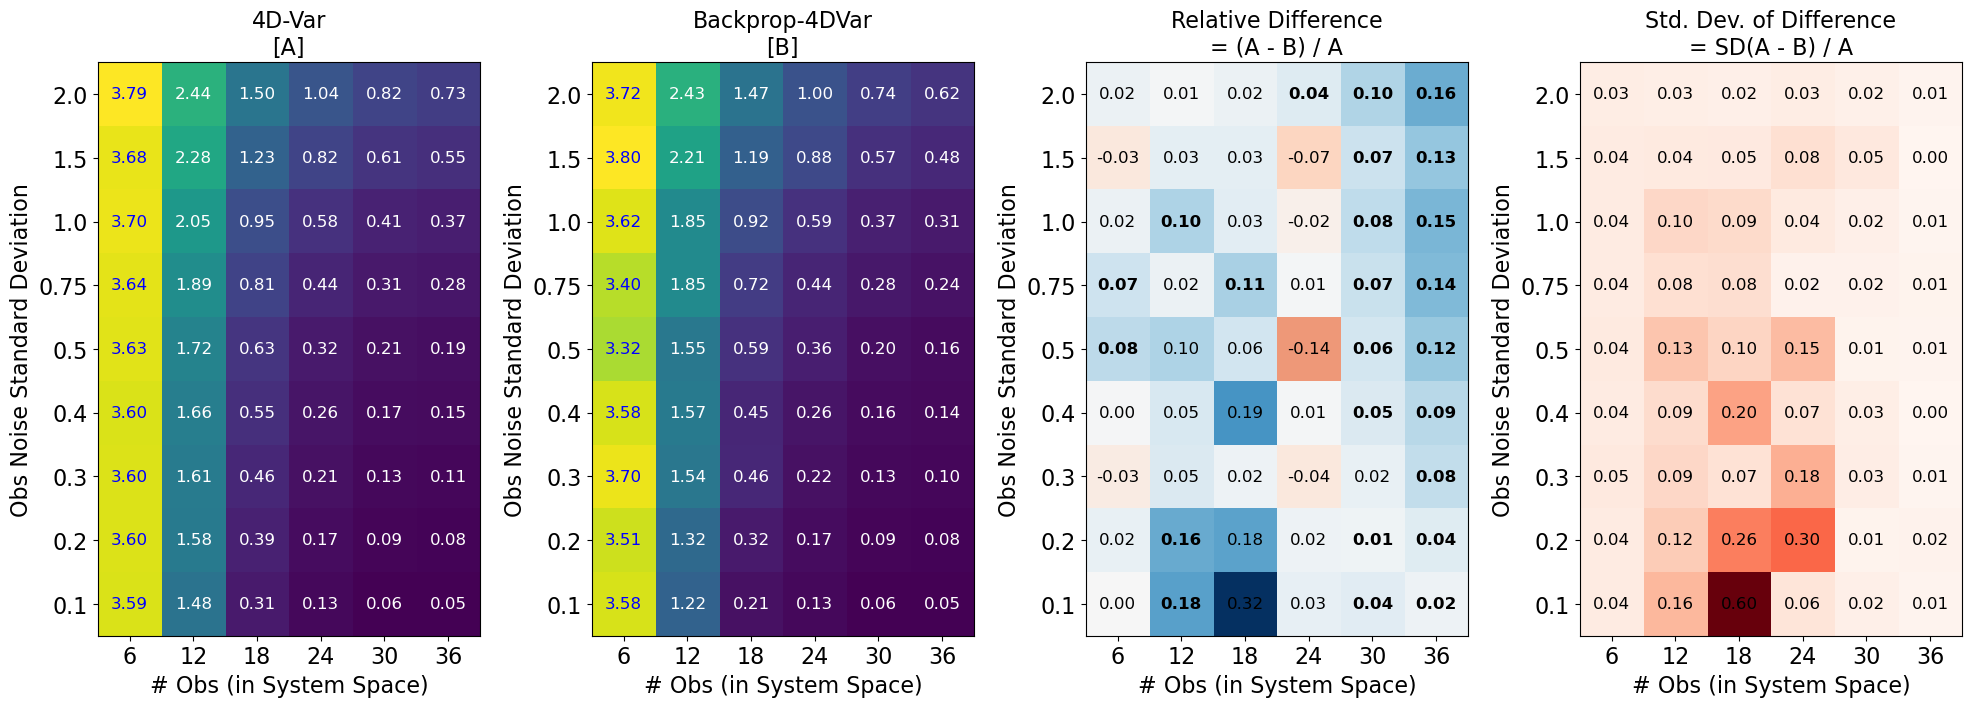

In [16]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 4, figsize = (20, 10))

num_obs_list = [6, 12, 18, 24, 30, 36]
# obs_error_list = np.arange(1.0, 0.05, -0.1)
obs_error_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2.0]
obs_error_list.reverse()
# Var4d
im = axs[0].imshow(var4d_array,
                   vmin = np.min(np.concatenate([bp_array, var4d_array])),
                   vmax = np.max(np.concatenate([bp_array, var4d_array])))

# Loop over data dimensions and create text annotations.
for i in range(len(num_obs_list)):
    for j in range(len(obs_error_list)):
        if i ==0:
            text_color = 'b'
        else:
            text_color = 'w'
        text = axs[0].text(i, j, "%.2f" % np.round(var4d_array[j,i],2),
                        ha="center", va="center", color=text_color, size=12)
            
# BP
im = axs[1].imshow(bp_array,
                   vmin = np.min(np.concatenate([bp_array, var4d_array])),
                   vmax = np.max(np.concatenate([bp_array, var4d_array])))

# Loop over data dimensions and create text annotations.
for i in range(len(num_obs_list)):
    for j in range(len(obs_error_list)):
        if i ==0:
            text_color = 'b'
        else:
            text_color = 'w'
        text = axs[1].text(i, j, "%.2f" % np.round(bp_array[j,i],2),
                        ha="center", va="center", color=text_color, size=12)
            
# Difference         
diff = (var4d_array - bp_array)/var4d_array
im = axs[2].imshow(diff, vmin=-1*np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), cmap='RdBu')

ij_diff_bigger_than_sd = np.abs(diff) > diff_array_sd

# Loop over data dimensions and create text annotations.
for i in range(len(num_obs_list)):
    for j in range(len(obs_error_list)):
        if ij_diff_bigger_than_sd[j, i]:
            text = axs[2].text(i, j, "%.2f" % np.round(diff[j,i],2),
                        ha="center", va="center", color="black", size=12, weight='bold')
        else:
             text = axs[2].text(i, j, "%.2f" % np.round(diff[j,i],2),
                        ha="center", va="center", color="black", size=12)
            
                   
# Difference SD       
im = axs[3].imshow(diff_array_sd, cmap='Reds')


# Loop over data dimensions and create text annotations.
for i in range(len(num_obs_list)):
    for j in range(len(obs_error_list)):
         text = axs[3].text(i, j, "%.2f" % np.round(diff_array_sd[j,i],2),
                        ha="center", va="center", color="black", size=12)
            
for ax_num in [0, 1, 2, 3]:
    axs[ax_num].set_xlabel('# Obs (in System Space)')
    axs[ax_num].set_ylabel('Obs Noise Standard Deviation')
    # Rotate the tick labels and set their alignment.
#     plt.setp(axs[ax_tuple].get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")
    # Show all ticks and label them with the respective list entries
    axs[ax_num].set_xticks(np.arange(len(num_obs_list)), labels=num_obs_list)
    axs[ax_num].set_yticks(np.arange(len(obs_error_list)), labels=np.round(obs_error_list, 2))

# Random text things
axs[0].set_title('4D-Var\n[A]',size=16)
axs[1].set_title('Backprop-4DVar\n[B]', size=16)
axs[2].set_title('Relative Difference\n= (A - B) / A', size=16)
axs[3].set_title('Std. Dev. of Difference\n= SD(A - B) / A', size=16)

# fig.suptitle('RMSE for 4DVar vs Backprop 4DVar',size=20)
# fig.colorbar(im)
fig.tight_layout()

# Contour plots

In [17]:
def load_pickle(pkl_path):
    with open(pkl_path, 'rb') as f:
        state_vec = pickle.load(f)
    return state_vec

In [18]:
nr_test = load_pickle('out/l96/l96_baserun_nr_18obs_36dim_v1.pkl')
nr_traj = dab.vector.StateVector(values=nr_test.values, times=nr_test.times)
nr_test.times-=np.min(nr_test.times)
nr_test.times*=5

In [19]:
obs_vec_test = load_pickle('out/l96/l96_4dvar_obsvec_18obs_36dim_v1.pkl')
obs_vec_test.times-=np.min(obs_vec_test.times)
obs_vec_test.times*=5
obs_x = np.repeat(obs_vec_test.times, 18)
obs_y = obs_vec_test.location_indices

In [20]:
baserun_traj = load_pickle('./out/l96/l96_baserun_results_18obs_36dim_v1.pkl')
var4d_traj = load_pickle('./out/l96/l96_4dvar_results_18obs_36dim_v1.pkl')
bp_traj = load_pickle('./out/l96/l96_bp_results_18obs_36dim_v1.pkl')
baserun_diff_vals = baserun_traj.values[:-20] - nr_traj.values[:-20]
bp_diff_vals = bp_traj.values - nr_traj.values[:-20]
var4d_diff_vals = var4d_traj.values -  nr_traj.values[:-20]

In [21]:
vals_list = [nr_traj.values[0:600].T, baserun_diff_vals[0:600].T,
             var4d_diff_vals[0:600].T, bp_diff_vals[0:600].T]

In [22]:
names_list = [
    'Nature Run',
    'Baseline (No DA)',
    '4D-Var (3 outer)',
    'BP-4DVar (3 iters, approx Hessian)'
    ]

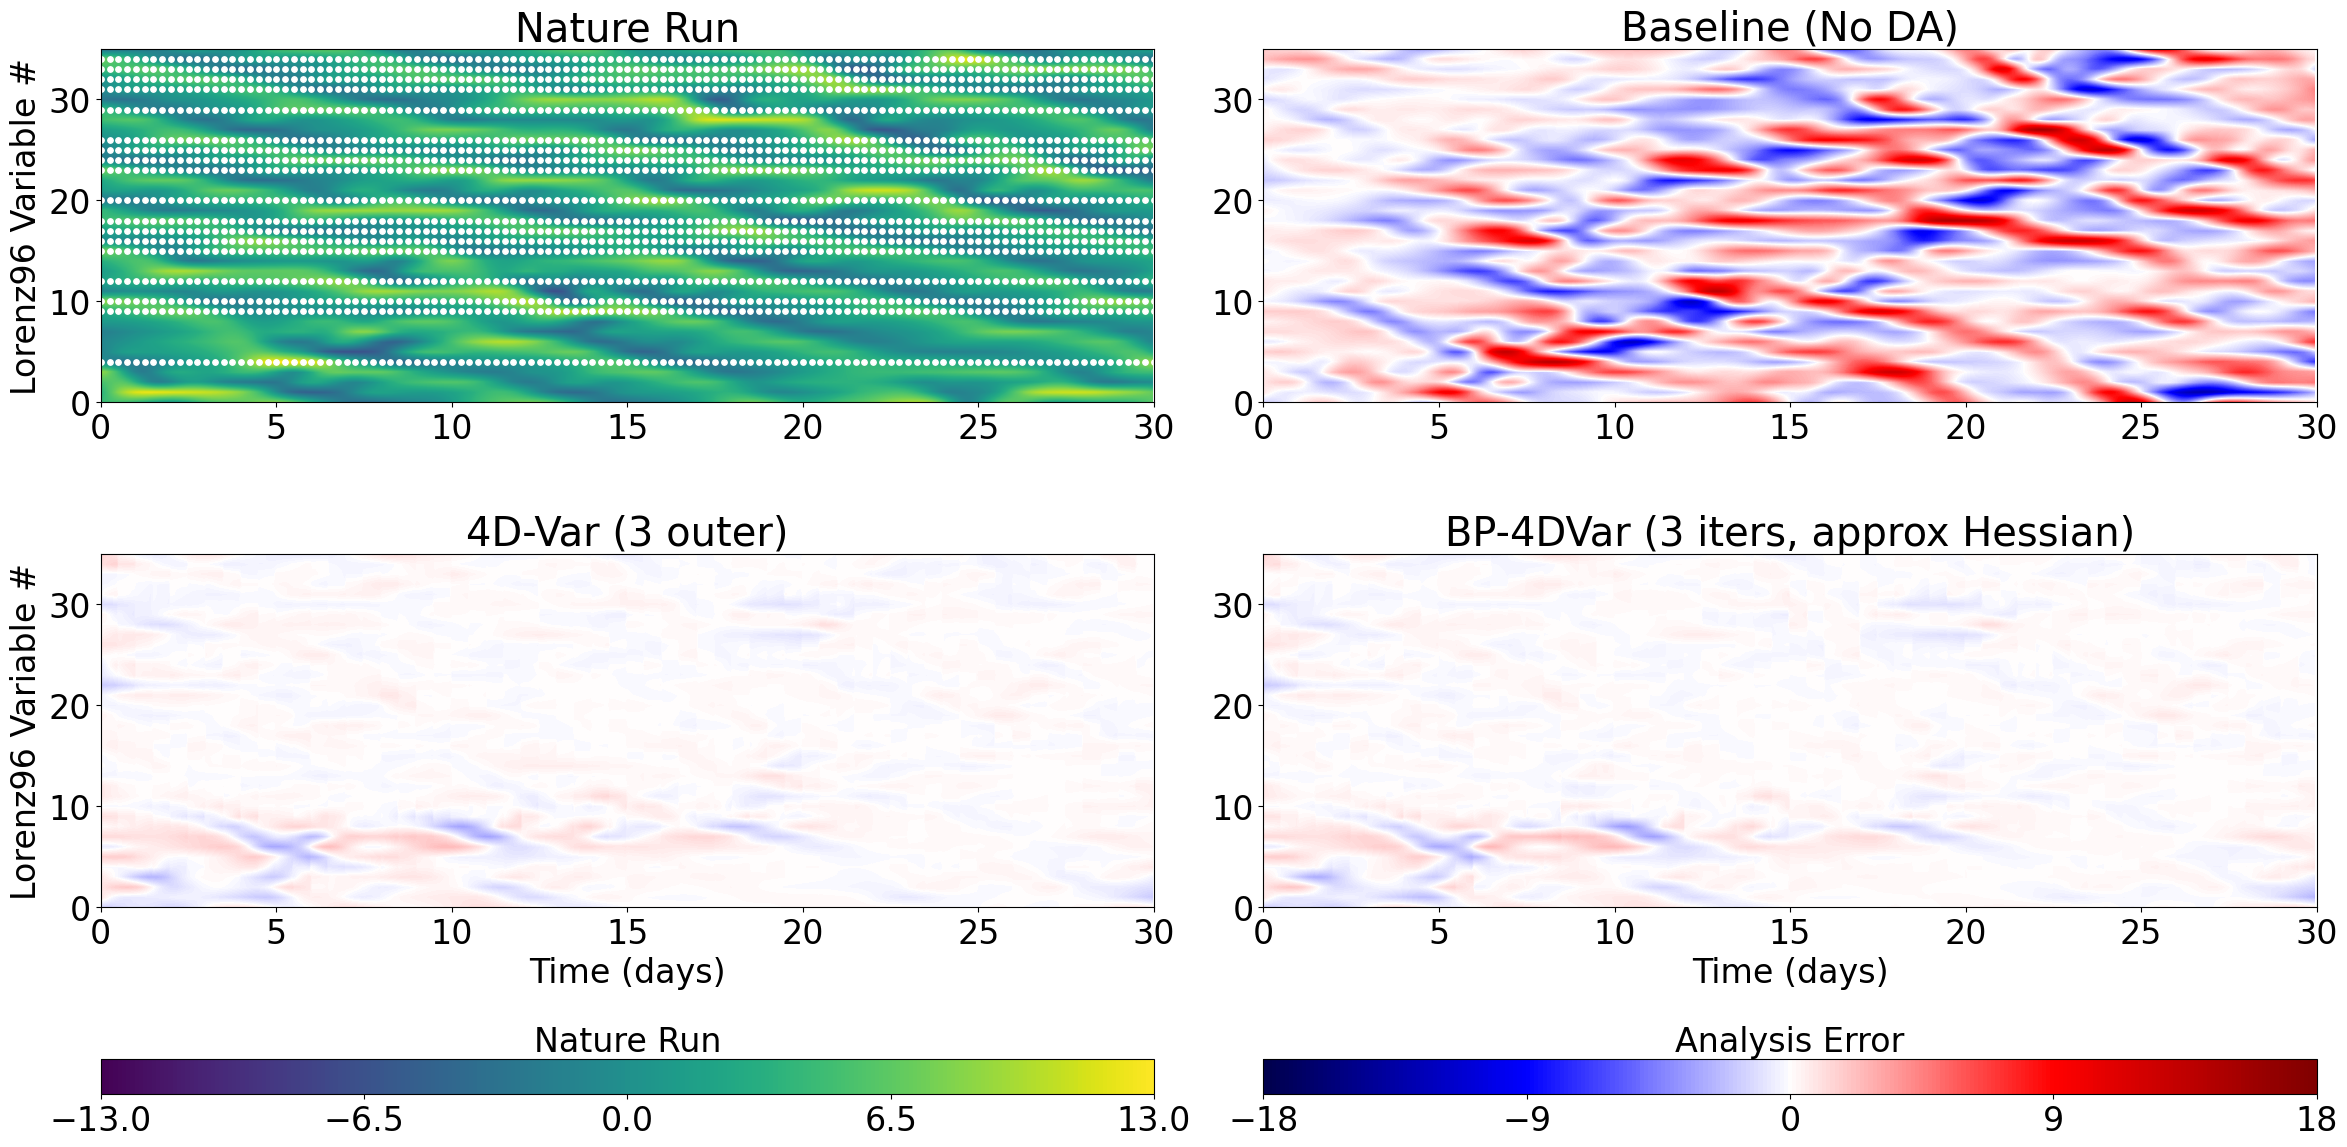

In [23]:
plt.rcParams.update({'font.size': 24})
axes_height_ratios = np.ones(3)
axes_height_ratios[2] = 0.1
fig, axs_grid = plt.subplots(3, 2, figsize = (24, 12),
                       gridspec_kw={"height_ratios":axes_height_ratios})#, 'hspace':0.275, 'wspace':0.05})
axs = axs_grid.flatten()
vmin_nr = -13
vmax_nr = 13
vmin_diff = -18
vmax_diff = 18

for i in range(4):
    if i ==0:
        vals = vals_list[i]
        cmap = 'viridis'
        v = np.linspace(vmin_nr, vmax_nr, 250, endpoint=True)
        vticks = np.linspace(vmin_nr, vmax_nr, 5, endpoint=True)
        im1 = axs[i].contourf(nr_test.times[:600], np.arange(36), vals, v, cmap=cmap)
        fig.colorbar(im1, cax=axs_grid[2, 0], orientation="horizontal", boundaries=v, ticks=vticks)
        axs[i].scatter(obs_x, obs_y, color='white', s=15)
        axs[i].set_xlim(np.min(nr_test.times[:600]), np.max(nr_test.times[:600])+0.05)

    else:
        vals = vals_list[i]
        v = np.linspace(vmin_diff, vmax_diff, 250, endpoint=True)
        vticks = np.linspace(vmin_diff, vmax_diff, 5, endpoint=True)
        cmap = 'seismic'
        im2 = axs[i].contourf(nr_test.times[:600], np.arange(36), vals, v, cmap=cmap)
        if i == 1:
            fig.colorbar(im2, cax=axs_grid[2, 1], orientation="horizontal", boundaries=v, ticks=vticks)
        axs[i].set_xlim(np.min(nr_test.times[:600]), np.max(nr_test.times[:600])+0.05)

    axs[i].set_title(names_list[i])

axs_grid[0, 0].set_ylabel('Lorenz96 Variable #')
axs_grid[1, 0].set_ylabel('Lorenz96 Variable #')
axs_grid[1, 0].set_xlabel('Time (days)')
axs_grid[1, 1].set_xlabel('Time (days)')
axs_grid[2,0].set_title('Nature Run', {'fontsize':24})

axs_grid[2,1].set_title('Analysis Error', {'fontsize':24})

fig.tight_layout()
plt.show()